In [1]:
import os
import time
import warnings
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from deepMNN import correct_scanpy
from metrics import compute_entropy, silhouette_coeff_ASW
import anndata as ad
from torch.utils.data import Dataset
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data

import scanpy as sc
from src.models import scETM
from src.trainers import UnsupervisedTrainer,prepare_for_transfer
from src import  evaluate
sc.set_figure_params(dpi=120, dpi_save=250, fontsize=10, figsize=(10, 10), facecolor="white")


warnings.filterwarnings("ignore")

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100)
sc.settings.set_figure_params(dpi_save=300)
sc.logging.print_version_and_date()

os.environ["CUDA_VISIBLE_DEVICES"]="1"

Running Scanpy 1.8.2, on 2021-12-21 22:31.


In [2]:

mp_csvs = ['GSM2230761_mouse1_umifm_counts.csv', 'GSM2230762_mouse2_umifm_counts.csv']
mp_adatas = []
for fpath in mp_csvs:
    df = pd.read_csv(fpath, index_col=0)
    adata = ad.AnnData(X=df.iloc[:, 2:], obs=df.iloc[:, :2])
    mp_adatas.append(adata)
adata= ad.concat(mp_adatas, label="batch_indices")
adata

AnnData object with n_obs × n_vars = 1886 × 14878
    obs: 'barcode', 'assigned_cluster', 'batch_indices'

In [3]:
adata.X[0].size
torch_data = torch.from_numpy(adata.X)

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        self.encoder  =  nn.Sequential(
            nn.Linear(14878,50),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(50,14878),
            nn.ReLU()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded

class my_dataset(Dataset): 
    def __init__(self,data):
        self.data = data 
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        return self.data[index]

my_datasets = my_dataset(torch_data)
dataloader = Data.DataLoader(dataset= my_datasets, batch_size= 200, shuffle= True)
my_module = AutoEncoder().to("cuda:3")

In [5]:
my_module(my_datasets)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not my_dataset

In [28]:

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(my_module.parameters(),lr = 1e-3)
for epoch in range(100):
    for step,x in enumerate(dataloader):
        x = x.cuda()
        en_out,de_out = my_module(x)
        loss = criterion(de_out,x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
    print(loss)

tensor(11.8433, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(8.4418, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.1127, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(14.0989, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(10.8130, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.9041, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(4.9435, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(12.5691, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(6.4161, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(9.4226, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(15.5406, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(6.3171, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(6.5200, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(11.9771, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(4.6599, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(9.5458, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.4939, device='cuda:0', gr

In [3]:

# mp_csvs = ['GSM2230761_mouse1_umifm_counts.csv', 'GSM2230762_mouse2_umifm_counts.csv']
# mp_adatas = []
# for fpath in mp_csvs:
#     df = pd.read_csv(fpath, index_col=0)
#     adata = ad.AnnData(X=df.iloc[:, 2:], obs=df.iloc[:, :2])
#     mp_adatas.append(adata)
# mp = ad.concat(mp_adatas, label="batch_indices")
# mp

# adata = sc.read_h5ad('data/dataset5.h5ad')

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:,adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [4]:
batch_names = adata.obs['batch_indices'].value_counts().index.values
adatas = [adata[adata.obs['batch_indices'] == batch_names[i]] for i in range(0, len(batch_names))]

# Before batch correction

In [5]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
asw_raw = silhouette_coeff_ASW(adata,batch_key='batch_indices',celltype_key='assigned_cluster')
entropy_raw=compute_entropy(adata,batch_key='batch_indices',celltype_key='assigned_cluster')

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
Calculating entropy ...
use exist neighbors
Entropy calculated!


... storing 'barcode' as categorical
... storing 'assigned_cluster' as categorical
... storing 'batch_indices' as categorical


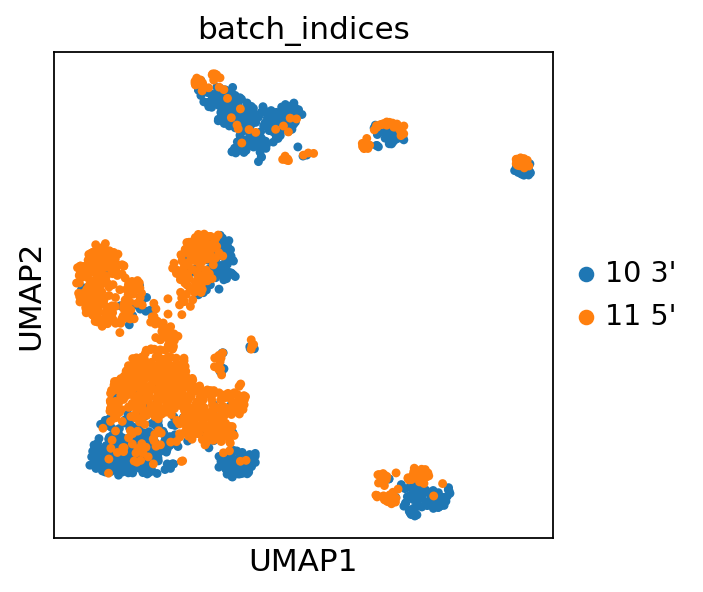

In [6]:
adata.obs['batch_indices'] = ['10 3\'' if i == '0' else '11 5\'' for i in adata.obs['batch_indices']]
sc.pl.umap(adata,color='batch_indices',save='_figure3_raw_batch.pdf')

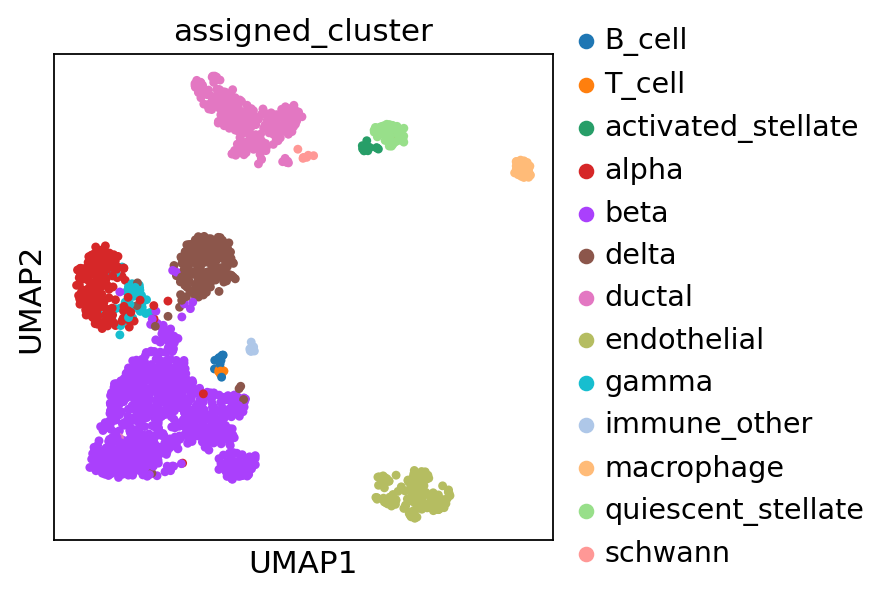

In [7]:
sc.pl.umap(adata,color='assigned_cluster',save='_figure3_raw_celltype.pdf')

# Batch correction using deepMNN

[[-0.42344117 -0.08713412 -0.06714797 ... -0.04766836  0.6865221
  -0.09253672]
 [-0.42344117 -0.08713412 -0.06714797 ... -0.04766836 -0.5474904
  -0.09253672]
 [ 0.4403095  -0.08713412 -0.06714797 ... -0.04766836  0.2779857
  -0.09253672]
 ...
 [-0.42344117 -0.08713412 -0.06714797 ... -0.04766836 -0.5474904
  -0.09253672]
 [-0.42344117 -0.08713412 -0.06714797 ... -0.04766836 -0.5474904
  -0.09253672]
 [-0.42344117 -0.08713412 -0.06714797 ... -0.04766836 -0.5474904
  -0.09253672]]
tensor(0.9572, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.9347, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.9285, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.9221, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.9145, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.9060, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.8968, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.8863, device='cuda:1', grad_fn=<MseLossBackward0>)
tensor(0.8747, device='cuda:1', gr

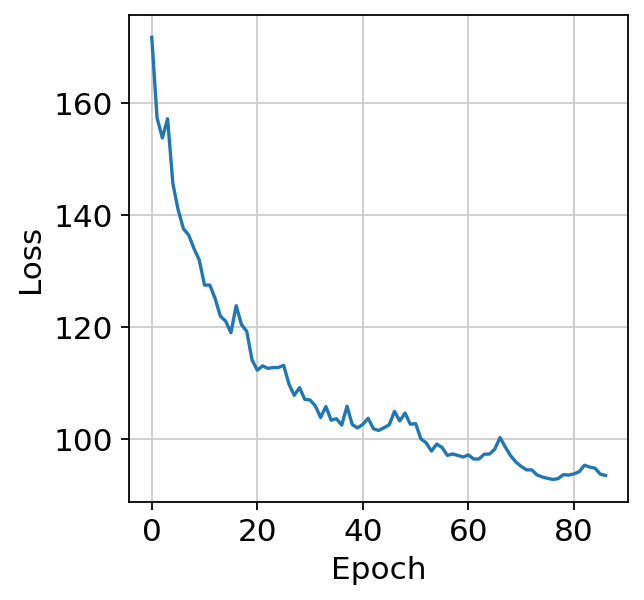

In [8]:
print(adatas[0].X)
time_s = time.time()
corrected = correct_scanpy(adatas,plot_loss= True)
print('time used:', time.time()-time_s)

adata_result = corrected[0].concatenate(corrected[1:], join='inner', batch_key = 'batch_indices')
sc.tl.pca(adata_result, svd_solver='arpack')
sc.pp.neighbors(adata_result)
sc.tl.umap(adata_result)

asw_deepMNN = silhouette_coeff_ASW(adata_result,batch_key='batch_indices',celltype_key='assigned_cluster')
entropy_deepMNN=compute_entropy(adata_result,celltype_key='assigned_cluster',batch_key='batch_indices')

... storing 'barcode' as categorical
... storing 'assigned_cluster' as categorical


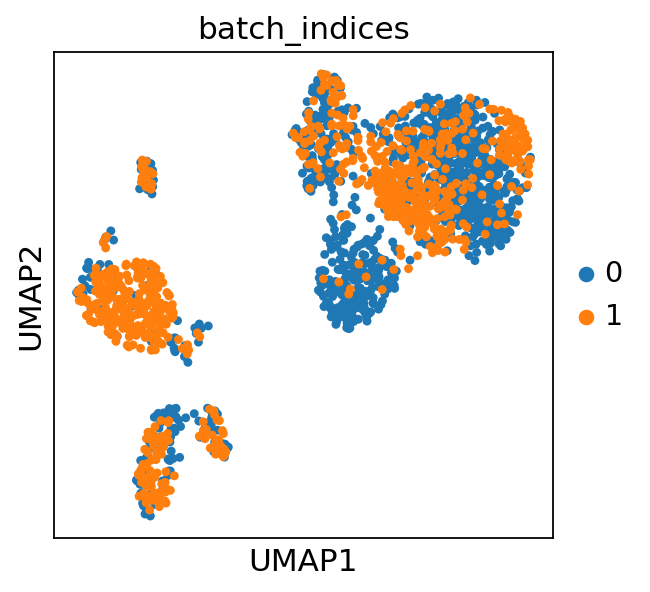

In [9]:
# adata_result.obs['batch_indices'] = ['10X 3\'' if i == '0' else '10X 5\'' for i in adata_result.obs['batch_indices']]

sc.pl.umap(adata_result,color='batch_indices',save='_figure3_deepMNN_batch.pdf')

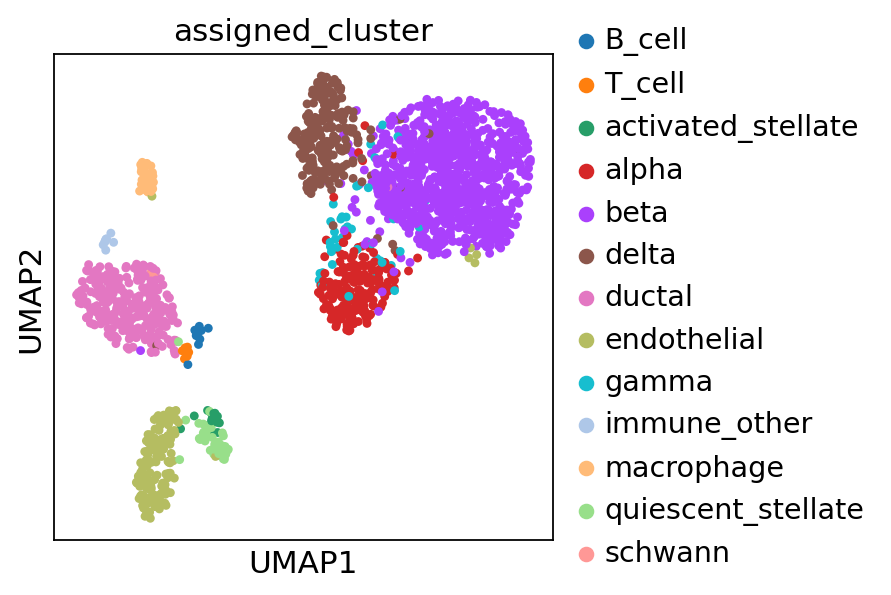

In [10]:
sc.pl.umap(adata_result,color='assigned_cluster',save='_figure3_deepMNN_celltype.pdf')

In [ ]:
ann_model = scETM(adata_result.n_vars,1,device="cuda:1")
trainer = UnsupervisedTrainer(ann_model, adata_result, test_ratio=0.1)
trainer.train(n_epochs = 12000, eval_every = 3000, eval_kwargs = dict(cell_type_col = 'assigned_cluster'), save_model_ckpt = False)

[2021-12-21 18:19:05,852] INFO - scETM.logging_utils: scETM.__init__(2000, 1, device = cuda:1)
caonima

n_batches == 1, disabling batch bias
[2021-12-21 18:19:05,868] INFO - scETM.logging_utils: UnsupervisedTrainer.__init__(scETM(
  (q_delta): Sequential(
    (0): Linear(in_features=2000, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
  )
  (mu_q_delta): Linear(in_features=2, out_features=50, bias=True)
  (logsigma_q_delta): Linear(in_features=2, out_features=50, bias=True)
  (rho_trainable_emb): PartlyTrainableParameter2D(height=400, fixed=0, trainable=2000)
), AnnData object with n_obs × n_vars = 1886 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indic

[2021-12-21 18:19:05,922] INFO - scETM.logging_utils: evaluate(adata = AnnData object with n_obs × n_vars = 1886 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors'
    obsm: 'X_pca', 'X_umap', 'delta'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', embedding_key = delta, batch_col = batch_indices, plot_fname = scETM_delta_epoch0, plot_dir = None, writer = None, cell_type_col = assigned_cluster)
[2021-12-21 18:19:06,220] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.01', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:19:06,318] INFO - scETM.eval_utils: Resolution:  0.01	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 2 clusters and added
    'leiden_0.02', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:19:06,392] INFO - scETM.eval_utils: Resolution:  0.02	ARI:  0.0179	NMI:  0.0334	bARI: -0.0075	# labels: 2


running Leiden clustering
    finished: found 2 clusters and added
    'leiden_0.04', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:19:06,467] INFO - scETM.eval_utils: Resolution:  0.04	ARI:  0.0179	NMI:  0.0334	bARI: -0.0075	# labels: 2


running Leiden clustering
    finished: found 2 clusters and added
    'leiden_0.08', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:19:06,547] INFO - scETM.eval_utils: Resolution:  0.08	ARI:  0.0179	NMI:  0.0334	bARI: -0.0075	# labels: 2


running Leiden clustering
    finished: found 2 clusters and added
    'leiden_0.16', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:19:06,620] INFO - scETM.eval_utils: Resolution:  0.16	ARI:  0.0161	NMI:  0.0337	bARI: -0.0081	# labels: 2


running Leiden clustering
    finished: found 2 clusters and added
    'leiden_0.32', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:19:06,694] INFO - scETM.eval_utils: Resolution:  0.32	ARI:  0.0155	NMI:  0.0334	bARI: -0.0083	# labels: 2


running Leiden clustering
    finished: found 2 clusters and added
    'leiden_0.64', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:19:06,767] INFO - scETM.eval_utils: Resolution:  0.64	ARI:  0.0160	NMI:  0.0339	bARI: -0.0084	# labels: 2
[2021-12-21 18:19:06,827] INFO - scETM.eval_utils: delta_ASW: -0.6778
[2021-12-21 18:19:06,842] INFO - scETM.eval_utils: SW: batch_indices                  0             1
assigned_cluster                              
B_cell             -8.429370e-08 -8.429370e-08
T_cell             -8.429370e-08 -8.429370e-08
activated_stellate  0.000000e+00  0.000000e+00
alpha              -8.991644e-01 -8.326887e-01
beta               -9.697076e-01 -9.787696e-01
delta              -9.096458e-01 -9.425840e-01
ductal             -8.429370e-08 -2.237763e-03
endothelial        -8.429370e-08 -8.429370e-08
gamma              -8.729391e-01 -8.572354e-01
immune_other       -8.429370e-08 -8.429370e-08
macrophage         -8.429370e-08 -8.429370e-08
quiescent_stellate  0.000000e+00  0.000000e+00
schwann            -8.429370e-08 -8.429370e-08
[2021-12-21 18:19:06,843] INFO - scETM.eval_utils

[2021-12-21 18:19:41,205] INFO - scETM.logging_utils: evaluate(adata = AnnData object with n_obs × n_vars = 1886 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts', 'leiden_0.01', 'leiden_0.02', 'leiden_0.04', 'leiden_0.08', 'leiden_0.16', 'leiden_0.32', 'leiden_0.64', 'silhouette_width'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'delta', 'knn_indices'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', embedding_key = delta, batch_col = batch_indices, plot_fname = scETM_delta_epoch3000, plot_dir = None, writer = None, cell_type_col = assigned_cluster)
[2021-12-21 18:19:41,481] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.01', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:19:41,557] INFO - scETM.eval_utils: Resolution:  0.01	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.02', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:19:41,628] INFO - scETM.eval_utils: Resolution:  0.02	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.04', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:19:41,699] INFO - scETM.eval_utils: Resolution:  0.04	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.08', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:19:41,777] INFO - scETM.eval_utils: Resolution:  0.08	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.16', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:19:41,849] INFO - scETM.eval_utils: Resolution:  0.16	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.32', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:19:41,919] INFO - scETM.eval_utils: Resolution:  0.32	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 2 clusters and added
    'leiden_0.64', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:19:41,992] INFO - scETM.eval_utils: Resolution:  0.64	ARI:  0.0029	NMI:  0.0065	bARI: -0.0003	# labels: 2
[2021-12-21 18:19:42,077] INFO - scETM.eval_utils: delta_ASW: -0.6874
[2021-12-21 18:19:42,117] INFO - scETM.eval_utils: SW: batch_indices                  0         1
assigned_cluster                          
B_cell             -8.429370e-08 -0.003636
T_cell             -8.429370e-08 -0.003636
activated_stellate  0.000000e+00 -0.003636
alpha              -9.945071e-01 -1.000000
beta               -9.996949e-01 -0.996781
delta              -9.817702e-01 -0.976376
ductal             -8.429370e-08  0.001647
endothelial        -8.429370e-08 -0.003535
gamma              -8.429370e-08 -0.003636
immune_other       -8.429370e-08 -0.003636
macrophage         -8.429370e-08 -0.003636
quiescent_stellate  0.000000e+00 -0.003386
schwann            -8.429370e-08 -0.002424
[2021-12-21 18:19:42,118] INFO - scETM.eval_utils: Calculating batch mixing entropy...
[2021-12-21 18:19:42,9

[2021-12-21 18:20:14,521] INFO - scETM.logging_utils: evaluate(adata = AnnData object with n_obs × n_vars = 1886 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts', 'leiden_0.01', 'leiden_0.02', 'leiden_0.04', 'leiden_0.08', 'leiden_0.16', 'leiden_0.32', 'leiden_0.64', 'silhouette_width'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'delta', 'knn_indices'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', embedding_key = delta, batch_col = batch_indices, plot_fname = scETM_delta_epoch6000, plot_dir = None, writer = None, cell_type_col = assigned_cluster)
[2021-12-21 18:20:14,777] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.01', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:20:14,848] INFO - scETM.eval_utils: Resolution:  0.01	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.02', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:20:14,916] INFO - scETM.eval_utils: Resolution:  0.02	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.04', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:20:14,985] INFO - scETM.eval_utils: Resolution:  0.04	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.08', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:20:15,054] INFO - scETM.eval_utils: Resolution:  0.08	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.16', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:20:15,123] INFO - scETM.eval_utils: Resolution:  0.16	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.32', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:20:15,192] INFO - scETM.eval_utils: Resolution:  0.32	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.64', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:20:15,264] INFO - scETM.eval_utils: Resolution:  0.64	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1
[2021-12-21 18:20:15,344] INFO - scETM.eval_utils: delta_ASW: -0.2153
[2021-12-21 18:20:15,376] INFO - scETM.eval_utils: SW: batch_indices                  0             1
assigned_cluster                              
B_cell             -8.429370e-08 -8.429370e-08
T_cell             -8.429370e-08 -8.429370e-08
activated_stellate  0.000000e+00  0.000000e+00
alpha              -9.945054e-01 -9.999999e-01
beta               -8.429370e-08 -8.429370e-08
delta              -9.998358e-01 -9.763802e-01
ductal             -8.429370e-08 -8.429370e-08
endothelial        -8.429370e-08 -8.429370e-08
gamma              -8.429370e-08 -8.429370e-08
immune_other       -8.429370e-08 -8.429370e-08
macrophage         -8.429370e-08 -8.429370e-08
quiescent_stellate  0.000000e+00  0.000000e+00
schwann            -8.429370e-08 -8.429370e-08
[2021-12-21 18:20:15,378] INFO - scETM.eval_utils

[2021-12-21 18:20:43,853] INFO - scETM.logging_utils: evaluate(adata = AnnData object with n_obs × n_vars = 1886 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts', 'leiden_0.01', 'leiden_0.02', 'leiden_0.04', 'leiden_0.08', 'leiden_0.16', 'leiden_0.32', 'leiden_0.64', 'silhouette_width'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'delta', 'knn_indices'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', embedding_key = delta, batch_col = batch_indices, plot_fname = scETM_delta_epoch9000, plot_dir = None, writer = None, cell_type_col = assigned_cluster)
[2021-12-21 18:20:44,131] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.01', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:20:44,209] INFO - scETM.eval_utils: Resolution:  0.01	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.02', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:20:44,276] INFO - scETM.eval_utils: Resolution:  0.02	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.04', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:20:44,344] INFO - scETM.eval_utils: Resolution:  0.04	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.08', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:20:44,412] INFO - scETM.eval_utils: Resolution:  0.08	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.16', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:20:44,480] INFO - scETM.eval_utils: Resolution:  0.16	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.32', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:20:44,549] INFO - scETM.eval_utils: Resolution:  0.32	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 2 clusters and added
    'leiden_0.64', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:20:44,625] INFO - scETM.eval_utils: Resolution:  0.64	ARI:  0.0033	NMI:  0.0075	bARI:  0.0006	# labels: 2
[2021-12-21 18:20:44,699] INFO - scETM.eval_utils: delta_ASW: -0.6876
[2021-12-21 18:20:44,722] INFO - scETM.eval_utils: SW: batch_indices                  0         1
assigned_cluster                          
B_cell             -8.429370e-08 -0.003636
T_cell             -8.429370e-08 -0.003636
activated_stellate  0.000000e+00 -0.003636
alpha              -9.945058e-01 -1.000000
beta               -9.994935e-01 -0.996581
delta              -9.922780e-01 -0.966102
ductal             -8.429370e-08  0.001647
endothelial        -8.429370e-08 -0.003535
gamma              -8.429370e-08 -0.003636
immune_other       -8.429370e-08 -0.003636
macrophage         -8.429370e-08 -0.003636
quiescent_stellate  0.000000e+00 -0.003386
schwann            -8.429370e-08 -0.002424
[2021-12-21 18:20:44,724] INFO - scETM.eval_utils: Calculating batch mixing entropy...
[2021-12-21 18:20:45,5

[2021-12-21 18:21:12,633] INFO - scETM.logging_utils: evaluate(adata = AnnData object with n_obs × n_vars = 1886 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts', 'leiden_0.01', 'leiden_0.02', 'leiden_0.04', 'leiden_0.08', 'leiden_0.16', 'leiden_0.32', 'leiden_0.64', 'silhouette_width'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'delta', 'knn_indices'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', embedding_key = delta, batch_col = batch_indices, plot_fname = scETM_delta_epoch12000, plot_dir = None, writer = None, cell_type_col = assigned_cluster)
[2021-12-21 18:21:12,919] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.01', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:21:12,990] INFO - scETM.eval_utils: Resolution:  0.01	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.02', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:21:13,057] INFO - scETM.eval_utils: Resolution:  0.02	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.04', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:21:13,125] INFO - scETM.eval_utils: Resolution:  0.04	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.08', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:21:13,193] INFO - scETM.eval_utils: Resolution:  0.08	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.16', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:21:13,261] INFO - scETM.eval_utils: Resolution:  0.16	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.32', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:21:13,329] INFO - scETM.eval_utils: Resolution:  0.32	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.64', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:21:13,398] INFO - scETM.eval_utils: Resolution:  0.64	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1
[2021-12-21 18:21:13,474] INFO - scETM.eval_utils: delta_ASW: -0.2150
[2021-12-21 18:21:13,496] INFO - scETM.eval_utils: SW: batch_indices              0         1
assigned_cluster                      
B_cell              0.000000  0.000000
T_cell              0.000000  0.000000
activated_stellate  0.000000  0.000000
alpha              -0.994505 -1.000000
beta                0.000000  0.000000
delta              -1.000000 -0.969657
ductal              0.000000  0.000000
endothelial         0.000000  0.000000
gamma               0.000000  0.000000
immune_other        0.000000  0.000000
macrophage          0.000000  0.000000
quiescent_stellate  0.000000  0.000000
schwann             0.000000  0.000000
[2021-12-21 18:21:13,498] INFO - scETM.eval_utils: Calculating batch mixing entropy...
[2021-12-21 18:21:14,328] INFO - scETM.eval_utils: delta_BE:  0.0000
[2021-12-21 1

In [12]:
ann_model.get_cell_embeddings_and_nll(adata_result)

0.7481894629631164

[2021-12-21 18:21:15,144] INFO - scETM.logging_utils: evaluate(AnnData object with n_obs × n_vars = 1886 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts', 'leiden_0.01', 'leiden_0.02', 'leiden_0.04', 'leiden_0.08', 'leiden_0.16', 'leiden_0.32', 'leiden_0.64', 'silhouette_width'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'delta', 'knn_indices', 'theta'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', resolutions = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45], return_fig = True, cell_type_col = assigned_cluster, batch_col = batch_indices)
[2021-12-21 18:21:15,398] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.2', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:21:15,463] INFO - scETM.eval_utils: Resolution:   0.2	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.25', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:21:15,529] INFO - scETM.eval_utils: Resolution:  0.25	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.3', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:21:15,596] INFO - scETM.eval_utils: Resolution:   0.3	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.35', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:21:15,662] INFO - scETM.eval_utils: Resolution:  0.35	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.4', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:21:15,729] INFO - scETM.eval_utils: Resolution:   0.4	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1


running Leiden clustering
    finished: found 1 clusters and added
    'leiden_0.45', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-21 18:21:15,795] INFO - scETM.eval_utils: Resolution:  0.45	ARI:  0.0000	NMI:  0.0000	bARI:  0.0000	# labels: 1
[2021-12-21 18:21:15,860] INFO - scETM.eval_utils: delta_ASW: -0.2150
[2021-12-21 18:21:15,877] INFO - scETM.eval_utils: SW: batch_indices              0         1
assigned_cluster                      
B_cell              0.000000  0.000000
T_cell              0.000000  0.000000
activated_stellate  0.000000  0.000000
alpha              -0.994505 -1.000000
beta                0.000000  0.000000
delta              -1.000000 -0.969657
ductal              0.000000  0.000000
endothelial         0.000000  0.000000
gamma               0.000000  0.000000
immune_other        0.000000  0.000000
macrophage          0.000000  0.000000
quiescent_stellate  0.000000  0.000000
schwann             0.000000  0.000000
[2021-12-21 18:21:15,879] INFO - scETM.eval_utils: Calculating batch mixing entropy...
[2021-12-21 18:21:16,680] INFO - scETM.eval_utils: delta_BE:  0.0000
[2021-12-21 1

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


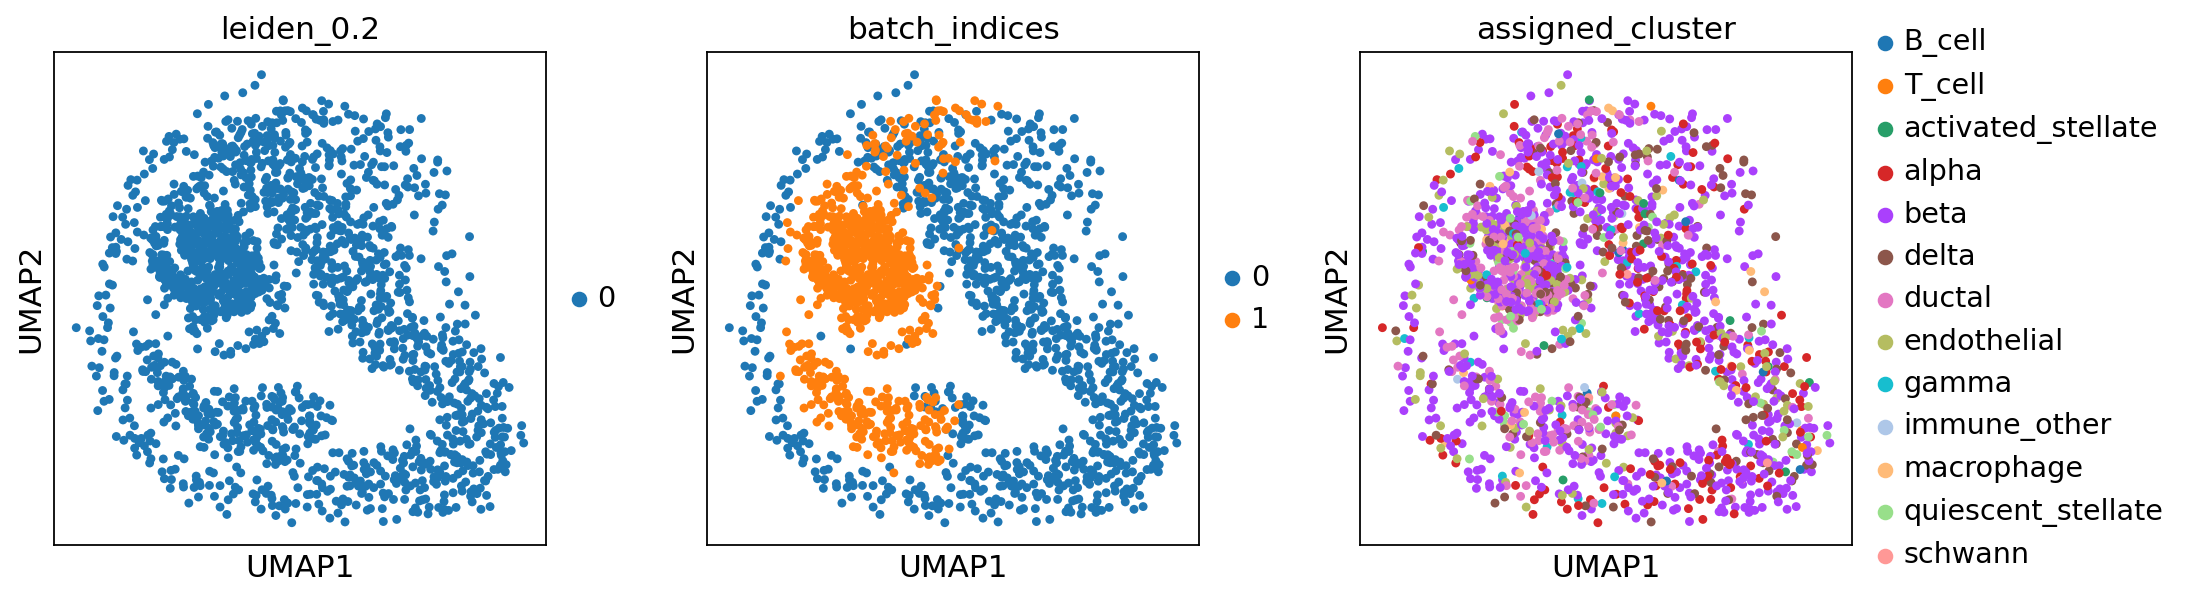

In [13]:
# result = evaluate(adata, resolutions = [0.1, 0.13, 0.19, 0.22, 0.25, 0.28], return_fig=True, cell_type_col="assigned_cluster", batch_col="batch_indices")
result = evaluate(adata_result, resolutions = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45], return_fig=True, cell_type_col="assigned_cluster", batch_col="batch_indices")

In [14]:
print("fuck you beach")

fuck you beach


# Batch correction using Scanorama

In [10]:
import scanorama

adata = sc.read_h5ad('data/dataset5.h5ad')

sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat')
adata = adata[:,adata.var['highly_variable']]

adatas = [adata[adata.obs['batch'] == i,:].copy() for i in ['0','1']]

time_s = time.time()
corrected = scanorama.correct_scanpy(adatas)
print('time used:', time.time()-time_s)

corrected_dataset = corrected[0].concatenate(corrected[1:], join='inner', batch_key = 'batch')
sc.tl.pca(corrected_dataset, svd_solver='arpack')
sc.pp.neighbors(corrected_dataset)
sc.tl.umap(corrected_dataset)

asw_Scanorama = silhouette_coeff_ASW(corrected_dataset)
entropy_Scanorama=compute_entropy(corrected_dataset)

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Found 2000 genes among all datasets
[[0.         0.53926896]
 [0.         0.        ]]
Processing datasets (0, 1)


computing PCA
    on highly variable genes
    with n_comps=50


time used: 37.03662467002869


    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)


Calculating entropy ...
use exist neighbors
Entropy calculated!


... storing 'batch' as categorical


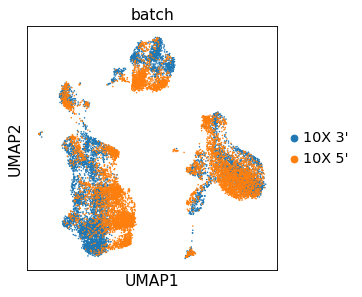

In [11]:
corrected_dataset.obs['batch'] = ['10X 3\'' if i == '0' else '10X 5\'' for i in corrected_dataset.obs['batch']]
sc.pl.umap(corrected_dataset,color='batch',save='_figure3_Scanorama_batch.pdf')

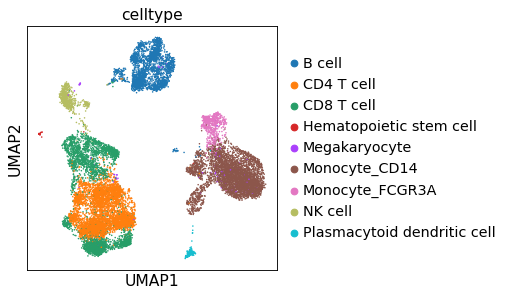

In [12]:
sc.pl.umap(corrected_dataset,color='celltype',save='_figure3_Scanorama_celltype.pdf')

In [14]:
#corrected_dataset.write('./processed_adata/adata_Scanorama_fig3.h5ad')

In [10]:
#adata_scan = sc.read_h5ad('/media/bgi/zhouruilong/deepMNN/processed_adata/fig3/adata_scanorama_fig3.h5ad')

# Batch correction using seurat

In [13]:
adata_seurat = sc.read_h5ad('/media/bgi/zhouruilong/genebank/zfssz2/ST_MCHRI/BIGDATA/USER/zhangtongda/ldfssz1_ztd_project/project/ZB_single_cell/20210610/fig3_seurat/batches.h5ad')

In [16]:
adata_seurat.obs['celltype'] = adata_seurat.obs['CellType']
del adata_seurat.obs['CellType']

In [17]:
sc.pp.neighbors(adata_seurat)
sc.tl.umap(adata_seurat)

asw_seurat = silhouette_coeff_ASW(adata_seurat)
entropy_seurat = compute_entropy(adata_seurat)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:28)


Calculating entropy ...
use exist neighbors
Entropy calculated!


... storing 'orig.ident' as categorical
... storing 'Sample' as categorical
... storing 'batch' as categorical
... storing 'anno' as categorical
... storing 'Method' as categorical
... storing 'batchlb' as categorical
... storing 'celltype' as categorical


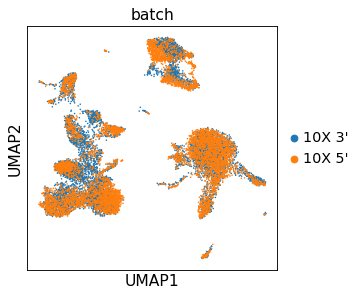

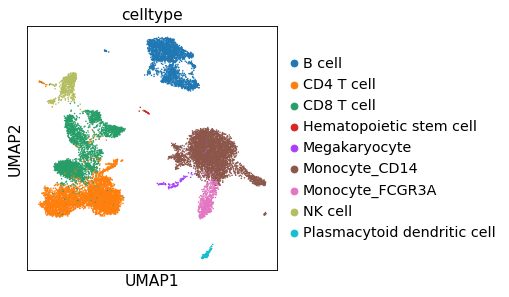

In [18]:
adata_seurat.obs['batch'] = ['10X 3\'' if i == 1.0 else '10X 5\'' for i in adata_seurat.obs['batch']]
sc.pl.umap(adata_seurat,color='batch',save='_figure3_seurat_batch.pdf')
sc.pl.umap(adata_seurat,color='celltype',save='_figure3_seurat_celltype.pdf')

In [19]:
adata_seurat.__dict__['_raw'].__dict__['_var'] = adata_seurat.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

In [20]:
adata_seurat.write('./processed_adata/adata_seurat_fig3.h5ad')

# Batch correction using harmony

In [21]:
adata_harmony = sc.read_h5ad('/media/bgi/zhouruilong/genebank/zfssz2/ST_MCHRI/BIGDATA/USER/zhangtongda/ldfssz1_ztd_project/project/ZB_single_cell/20210610/fig3_harmony/batches.h5ad')

In [22]:
adata_harmony.obsm['X_pca'] = adata_harmony.obsm['X_harmony']
adata_harmony.obs['celltype'] = adata_harmony.obs['CellType']
del adata_harmony.obs['CellType']
sc.pp.neighbors(adata_harmony)
sc.tl.umap(adata_harmony)

asw_harmony = silhouette_coeff_ASW(adata_harmony)
entropy_harmony = compute_entropy(adata_harmony)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:28)


Calculating entropy ...
use exist neighbors
Entropy calculated!


... storing 'Sample' as categorical
... storing 'batch' as categorical
... storing 'anno' as categorical
... storing 'Method' as categorical
... storing 'batchlb' as categorical
... storing 'celltype' as categorical


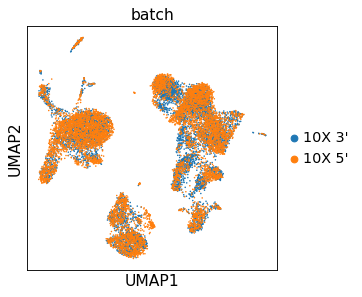

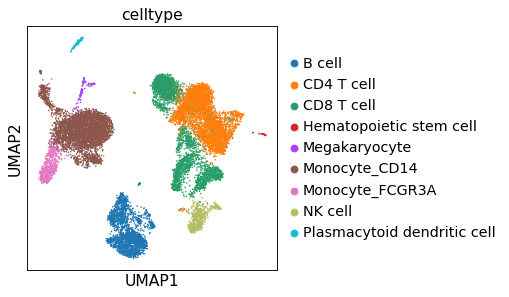

In [23]:
adata_harmony.obs['batch'] = ['10X 3\'' if i == 1.0 else '10X 5\'' for i in adata_harmony.obs['batch']]
sc.pl.umap(adata_harmony,color='batch',save='_figure3_harmony_batch.pdf')
sc.pl.umap(adata_harmony,color='celltype',save='_figure3_harmony_celltype.pdf')

In [24]:
adata_harmony

AnnData object with n_obs × n_vars = 15476 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'cell', 'batchlb', 'celltype'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors', 'umap', 'batch_colors', 'celltype_colors'
    obsm: 'X_harmony', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'HARMONY', 'PCs'
    obsp: 'distances', 'connectivities'

In [25]:
adata_harmony.write('./processed_adata/adata_harmony_fig3.h5ad')

# Batch correction using MMD

In [32]:
asw_MMD = pd.read_csv('/media/bgi/zhouruilong/deepMNN/csv_result/fig3/asw_MMD_fig3.csv')
entropy_MMD = pd.read_csv('/media/bgi/zhouruilong/deepMNN/csv_result/fig3/entropy_MMD_fig3.csv')

# Batch correction using scGen

In [33]:
asw_scgen = pd.read_csv('/media/bgi/zhouruilong/deepMNN/csv_result/fig3/asw_scgen_fig3.csv')
entropy_scgen = pd.read_csv('/media/bgi/zhouruilong/deepMNN/csv_result/fig3/entropy_scgen_fig3.csv')

# Save metrics

In [34]:
#Raw
asw_raw.to_csv('./csv_result/fig3/asw_raw_fig3.csv',index=0)
entropy_raw.to_csv('./csv_result/fig3/entropy_raw_fig3.csv',index=0)

#MMD-ResNet
asw_MMD.to_csv('./csv_result/fig3/asw_MMD_fig3.csv',index=0)
entropy_MMD.to_csv('./csv_result/fig3/entropy_MMD_fig3.csv',index=0)

#scGen
asw_scgen.to_csv('./csv_result/fig3/asw_scgen_fig3.csv',index=0)
entropy_scgen.to_csv('./csv_result/fig3/entropy_scgen_fig3.csv',index=0)

#Seurat V4
asw_seurat.to_csv('./csv_result/fig3/asw_seurat_fig3.csv',index=0)
entropy_seurat.to_csv('./csv_result/fig3/entropy_seurat_fig3.csv',index=0)

#Harmony
asw_harmony.to_csv('./csv_result/fig3/asw_harmony_fig3.csv',index=0)
entropy_harmony.to_csv('./csv_result/fig3/entropy_harmony_fig3.csv',index=0)

#Scanorama
asw_Scanorama.to_csv('./csv_result/fig3/asw_Scanorama_fig3.csv',index=0)
entropy_Scanorama.to_csv('./csv_result/fig3/entropy_Scanorama_fig3.csv',index=0)

#deepMNN
asw_deepMNN.to_csv('./csv_result/fig3/asw_deepMNN_fig3.csv',index=0)
entropy_deepMNN.to_csv('./csv_result/fig3/entropy_deepMNN_fig3.csv',index=0)

# Metrics

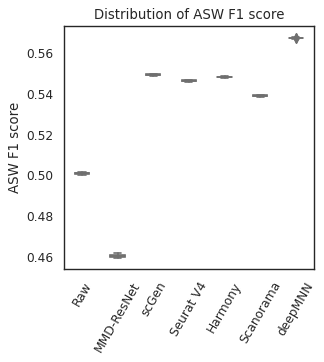

In [46]:
asw_df = pd.DataFrame()
asw_df['ASW F1 score'] = asw_raw['fscore'].tolist() + asw_MMD['fscore'].tolist() + asw_scgen['fscore'].tolist() + asw_seurat['fscore'].tolist() + asw_harmony['fscore'].tolist() + asw_Scanorama['fscore'].tolist() + asw_deepMNN['fscore'].tolist() 
asw_df['Methods'] = (['Raw'] * asw_raw.shape[0] + 
                     ['MMD-ResNet'] * asw_raw.shape[0] + 
                     ['scGen'] * asw_raw.shape[0] +
                     ['Seurat V4'] * asw_raw.shape[0] +
                     ['Harmony'] * asw_raw.shape[0] +
                     ['Scanorama'] * asw_raw.shape[0] +
                     ['deepMNN'] * asw_raw.shape[0])

# plt.figure(dpi=300)

sns.set_theme(style='white', palette='pastel')
sns.boxplot(x='Methods', y='ASW F1 score', width=0.4, data=asw_df)
plt.title('Distribution of ASW F1 score')
plt.xlabel('')
plt.xticks(rotation=60)
plt.savefig('figures/ASW_F1_score_figure3.pdf', format='pdf', dpi=300, bbox_inches='tight')

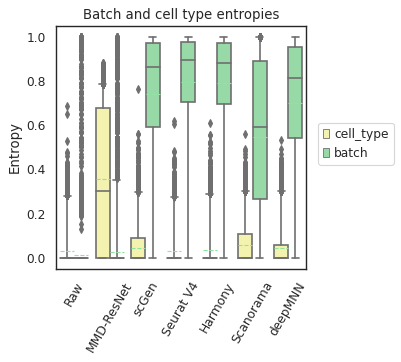

In [45]:
entropy_df = pd.DataFrame()
entropy_df['Entropy'] = (entropy_raw['cell_type'].tolist() + entropy_raw['batch'].tolist() + 
                         entropy_MMD['cell_type'].tolist() + entropy_MMD['batch'].tolist() +
                         entropy_scgen['cell_type'].tolist() + entropy_scgen['batch'].tolist() + 
                         entropy_seurat['cell_type'].tolist() + entropy_seurat['batch'].tolist() +
                         entropy_harmony['cell_type'].tolist() + entropy_harmony['batch'].tolist() +
                         entropy_Scanorama['cell_type'].tolist() + entropy_Scanorama['batch'].tolist() +
                         entropy_deepMNN['cell_type'].tolist() + entropy_deepMNN['batch'].tolist())

entropy_df['Methods'] = (['Raw'] * entropy_raw.shape[0] * 2 + 
                         ['MMD-ResNet'] * entropy_raw.shape[0] * 2 + 
                         ['scGen'] * entropy_raw.shape[0] * 2 +
                         ['Seurat V4'] * entropy_raw.shape[0] * 2 +
                         ['Harmony'] * entropy_raw.shape[0] * 2 +
                         ['Scanorama'] * entropy_raw.shape[0] * 2 +
                         ['deepMNN'] * entropy_raw.shape[0] * 2)

entropy_df['Entropy_type'] = (['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0] + 
                              ['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0] + 
                              ['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0] +
                              ['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0] +
                              ['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0] +
                              ['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0] +
                              ['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0])

# plt.figure(dpi=300)

sns.set_theme(style='white', palette="pastel")

sns.boxplot(x='Methods', y='Entropy', whis=(2.5,97.5), showmeans=True, meanline=True,
            hue='Entropy_type', palette=['y', 'g'], data=entropy_df)
plt.title('Batch and cell type entropies')
plt.xlabel('')
plt.xticks(rotation=60)
plt.legend(bbox_to_anchor=(1.05, 0.6), borderaxespad=0)
plt.savefig('figures/Entropy_figure3.pdf', format='pdf', dpi=300, bbox_inches='tight')